# 9章 データの集約とグループ演算

In [1]:
from __future__ import division
from numpy.random import randn
import numpy as np
import os
import matplotlib.pyplot as plt
np.random.seed(12345)
plt.rc('figure', figsize=(10, 6))
from pandas import Series, DataFrame
import pandas as pd
np.set_printoptions(precision=4)

In [2]:
#pd.options.display.notebook_repr_html = False

In [3]:
%matplotlib inline

- この章で学ぶこと
 - pandas のオブジェクトを 1 つあるいは複数のキー（関数や配列、データフレームの列名の形式で 指定）を用いて分割する方法。
 -  グループの要約統計量の計算方法。具体的には、個数のカウント、中央値、標準偏差や、ユーザが 定義した関数などの計算方法。
 -  さまざまな関数のセットをデータフレームのそれぞれの列に適用する方法。
 -  グループ内の変換やその他のデータ操作（正規化、線形回帰、順位、部分集合の選択）。
 -  ピボットテーブルとクロス集計の計算。
 -  分位点分析やその他のデータから生成されたグループに関する分析

## 9.1 GroupBy の仕組み

- R 言語のさまざまな有名なパッケージを作っているハドレー・ウィッカム氏によって、
- グループ演算のプロセスを説明するために作られた言葉が
- **分離-適用-結合** (**split-apply-combine**)です。

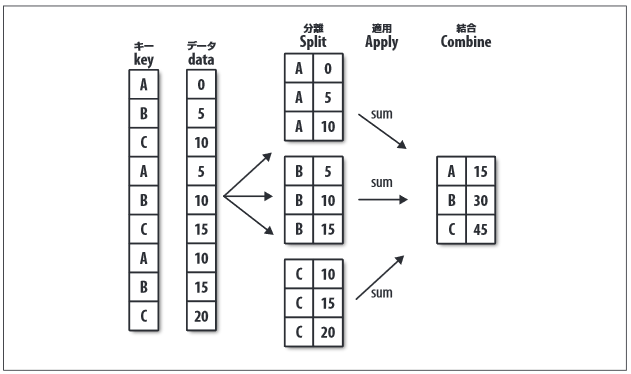

- グルーピングに使用するキーはさまざまな形式を取ることができ、
- また、すべて同じ型である必要もありません。

 -  値のリストや配列（グループされる軸と同じ長さのもの）
 <br><br>
 -  データフレームの列名を示す値
 - ディクショナリ形式あるいはシリーズ形式（グループされる軸の値とグループ名の間の対応が取れている場合）
 -  軸のインデックスあるいはそれぞれのインデックスのラベルに対して呼び出される関数
<br><br> 
- この手法のうち後者 3 つは、オブジェクトを分離するために使う値の配列を簡単に生成する手段です

In [4]:
df = DataFrame({'key1' : ['a', 'a', 'b', 'b', 'a'],
                'key2' : ['one', 'two', 'one', 'two', 'one'],
                'data1' : np.random.randn(5),
                'data2' : np.random.randn(5)})
df

,data1,data2,key1,key2
0,-0.204708,1.393406,a,one
1,0.478943,0.092908,a,two
2,-0.519439,0.281746,b,one
3,-0.555730,0.769023,b,two
4,1.965781,1.246435,a,one


- groupby の引数は 列オブジェクト(Series)
- 戻り値は SeriesGroupBy オブジェクト

In [5]:
grouped = df['data1'].groupby(df['key1'])
grouped

In [6]:
"""
内部的にGroupByに対応する中間データが生成さる(SeriesGroupByオブジェクト)
オブジェクトを生成後に、集合関数を指定したほうが効率がイイ!?(再利用できる)
以前は、how=集合関数 形式だった (depricated)
"""
print( type(grouped) )
print( list(grouped) )

<class 'pandas.core.groupby.SeriesGroupBy'>
[('a', 0   -0.204708
1    0.478943
4    1.965781
Name: data1, dtype: float64), ('b', 2   -0.519439
3   -0.555730
Name: data1, dtype: float64)]


In [7]:
""" データ列を指定しないと全ての列が対象となっている"""
""" select * from hoge group by 的なこと """
list(df.groupby("key1"))

[('a',       data1     data2 key1 key2
  0 -0.204708  1.393406    a  one
  1  0.478943  0.092908    a  two
  4  1.965781  1.246435    a  one), ('b',       data1     data2 key1 key2
  2 -0.519439  0.281746    b  one
  3 -0.555730  0.769023    b  two)]

In [8]:
"""groupByオブジェクトに集合演算を行う"""
grouped.mean()

key1
a    0.746672
b   -0.537585
Name: data1, dtype: float64

In [9]:
means = df['data1'].groupby([df['key1'], df['key2']]).mean()
means

key1  key2
a     one     0.880536
      two     0.478943
b     one    -0.519439
      two    -0.555730
Name: data1, dtype: float64

In [10]:
means.unstack()

key2,one,two
key1,,
a,0.880536,0.478943
b,-0.519439,-0.555730


- 配列をグルーピングのキーにすることもデキル (pd.Series)
- 外側から配列としてグルーピングのキーを与える (長さは同じでなくてはならない)
- ~~何かちょっと、釈然としないが・・~~

In [11]:
states = np.array(['Ohio', 'California', 'California', 'Ohio', 'Ohio'])
years = np.array([2005, 2005, 2006, 2005, 2006])
df['data1'].groupby([states, years]).mean()

California  2005    0.478943
            2006   -0.519439
Ohio        2005   -0.380219
            2006    1.965781
Name: data1, dtype: float64

In [12]:
df.groupby('key1').mean()

,data1,data2
key1,,
a,0.746672,0.910916
b,-0.537585,0.525384


In [13]:
df.groupby(['key1', 'key2']).mean()

data1     data2
key1 key2                    
a    one   0.880536  1.319920
     two   0.478943  0.092908
b    one  -0.519439  0.281746
     two  -0.555730  0.769023

In [14]:
df.groupby(['key1', 'key2']).count()

data1  data2
key1 key2              
a    one       2      2
     two       1      1
b    one       1      1
     two       1      1

### 9.1.1 グループをまたいだ繰り返し

- df.groupby('key1') => 戻り値は、階層インデックスを持つ DataFrame オブジェクト
- key => DataFrame as value

In [15]:
for name, group in df.groupby('key1'):
    print(name) #  グループの名前 => a, b 
    print(group) # その内容 

a
      data1     data2 key1 key2
0 -0.204708  1.393406    a  one
1  0.478943  0.092908    a  two
4  1.965781  1.246435    a  one
b
      data1     data2 key1 key2
2 -0.519439  0.281746    b  one
3 -0.555730  0.769023    b  two


In [16]:
type(df.groupby('key1'))

pandas.core.groupby.DataFrameGroupBy

In [17]:
list(df.groupby('key1'))

[('a',       data1     data2 key1 key2
  0 -0.204708  1.393406    a  one
  1  0.478943  0.092908    a  two
  4  1.965781  1.246435    a  one), ('b',       data1     data2 key1 key2
  2 -0.519439  0.281746    b  one
  3 -0.555730  0.769023    b  two)]

- 複合キーの場合は、keyの部分がタプルで
- key(Tuple) => value(DataFrame)

In [18]:
for (k1, k2), group in df.groupby(['key1', 'key2']):
    print((k1, k2))
    print(group)

('a', 'one')
      data1     data2 key1 key2
0 -0.204708  1.393406    a  one
4  1.965781  1.246435    a  one
('a', 'two')
      data1     data2 key1 key2
1  0.478943  0.092908    a  two
('b', 'one')
      data1     data2 key1 key2
2 -0.519439  0.281746    b  one
('b', 'two')
     data1     data2 key1 key2
3 -0.55573  0.769023    b  two


- データをディクショナリ形式にするワンライナー
- これはいいかも

In [19]:
pieces = dict(list(df.groupby('key1')))
pieces['b']

,data1,data2,key1,key2
2,-0.519439,0.281746,b,one
3,-0.555730,0.769023,b,two


In [20]:
df.groupby('key1')

In [21]:
list(df.groupby('key1'))

[('a',       data1     data2 key1 key2
  0 -0.204708  1.393406    a  one
  1  0.478943  0.092908    a  two
  4  1.965781  1.246435    a  one), ('b',       data1     data2 key1 key2
  2 -0.519439  0.281746    b  one
  3 -0.555730  0.769023    b  two)]

In [22]:
dict(list(df.groupby('key1')))['a'] # それぞれは、dataframe

,data1,data2,key1,key2
0,-0.204708,1.393406,a,one
1,0.478943,0.092908,a,two
4,1.965781,1.246435,a,one


In [23]:
pieces.keys()

dict_keys(['a', 'b'])

In [24]:
df.dtypes

data1    float64
data2    float64
key1      object
key2      object
dtype: object

In [25]:
grouped = df.groupby(df.dtypes, axis=1)

In [26]:
dict(list(grouped))[df.dtypes[0]] #.[dtype("float64")] ではNG
dict(list(grouped))[np.array([0]).astype(np.float64).dtype] #.納得にいかない無理矢理感！

,data1,data2
0,-0.204708,1.393406
1,0.478943,0.092908
2,-0.519439,0.281746
3,-0.555730,0.769023
4,1.965781,1.246435


In [27]:
np.array([0]).astype(np.float64).dtype

dtype('float64')

### 9.1.2 列や列の集合の選択

In [28]:
df.groupby('key1')['data1']
df.groupby('key1')[['data2']]

In [29]:
"""上記と同じ (上記は下記のSyntax Sugar)"""
df['data1'].groupby(df['key1'])
df[['data2']].groupby(df['key1'])

In [30]:
df.groupby(['key1', 'key2'])[['data2']].mean()

data2
key1 key2          
a    one   1.319920
     two   0.092908
b    one   0.281746
     two   0.769023

In [31]:
s_grouped = df.groupby(['key1', 'key2'])['data2']
s_grouped

In [32]:
s_grouped.mean()

key1  key2
a     one     1.319920
      two     0.092908
b     one     0.281746
      two     0.769023
Name: data2, dtype: float64

### 9.1.3 ディクショナリ形式やシリーズのグルーピング

In [33]:
people = DataFrame(np.random.randn(5, 5),
                   columns=['a', 'b', 'c', 'd', 'e'],
                   index=['Joe', 'Steve', 'Wes', 'Jim', 'Travis'])
#people.ix[2:3, ['b', 'c']] = np.nan # Add a few NA values # deplicated
people.loc[2:3, ['b', 'c']] = np.nan # Add a few NA values
people

,a,b,c,d,e
Joe,1.007189,-1.296221,0.274992,0.228913,1.352917
Steve,0.886429,-2.001637,-0.371843,1.669025,-0.438570
Wes,-0.539741,NaN,NaN,-1.021228,-0.577087
Jim,0.124121,0.302614,0.523772,0.000940,1.343810
Travis,-0.713544,-0.831154,-2.370232,-1.860761,-0.860757


In [34]:
mapping = {'a': 'red', 'b': 'red', 'c': 'blue',
           'd': 'blue', 'e': 'red', 'f' : 'orange'}

In [35]:
"""列方向にgroupby"""
by_column = people.groupby(mapping, axis=1)
by_column.sum()

,blue,red
Joe,0.503905,1.063885
Steve,1.297183,-1.553778
Wes,-1.021228,-1.116829
Jim,0.524712,1.770545
Travis,-4.230992,-2.405455


In [36]:
list( by_column )[0]

('blue',                c         d
 Joe     0.274992  0.228913
 Steve  -0.371843  1.669025
 Wes          NaN -1.021228
 Jim     0.523772  0.000940
 Travis -2.370232 -1.860761)

In [37]:
map_series = Series(mapping)
map_series

a       red
b       red
c      blue
d      blue
e       red
f    orange
dtype: object

In [38]:
people.groupby(map_series, axis=1).count()

,blue,red
Joe,2,3
Steve,2,3
Wes,1,2
Jim,2,3
Travis,2,3


### 9.1.4 関数を用いたグルーピング

In [39]:
people.groupby(len).sum()

,a,b,c,d,e
3,0.591569,-0.993608,0.798764,-0.791374,2.119639
5,0.886429,-2.001637,-0.371843,1.669025,-0.438570
6,-0.713544,-0.831154,-2.370232,-1.860761,-0.860757


In [40]:
key_list = ['one', 'one', 'one', 'two', 'two']
people.groupby([len, key_list]).min()

a         b         c         d         e
3 one -0.539741 -1.296221  0.274992 -1.021228 -0.577087
  two  0.124121  0.302614  0.523772  0.000940  1.343810
5 one  0.886429 -2.001637 -0.371843  1.669025 -0.438570
6 two -0.713544 -0.831154 -2.370232 -1.860761 -0.860757

### 9.1.5 インデックスレベルのグルーピング

In [41]:
columns = pd.MultiIndex.from_arrays([['US', 'US', 'US', 'JP', 'JP'],
                                    [1, 3, 5, 1, 3]], names=['cty', 'tenor'])
hier_df = DataFrame(np.random.randn(4, 5), columns=columns)
hier_df

cty          US                            JP          
tenor         1         3         5         1         3
0      0.560145 -1.265934  0.119827 -1.063512  0.332883
1     -2.359419 -0.199543 -1.541996 -0.970736 -1.307030
2      0.286350  0.377984 -0.753887  0.331286  1.349742
3      0.069877  0.246674 -0.011862  1.004812  1.327195

In [42]:
hier_df.groupby(level='cty', axis=1).count()

cty,JP,US
0,2,3
1,2,3
2,2,3
3,2,3


## 9.2 データの集約
- 集約というと、一般的には、何らかのデータ変形を行って配列からスカラー値を生成するようなことを指します
- 集約後に集合演算を行います

In [43]:
df

,data1,data2,key1,key2
0,-0.204708,1.393406,a,one
1,0.478943,0.092908,a,two
2,-0.519439,0.281746,b,one
3,-0.555730,0.769023,b,two
4,1.965781,1.246435,a,one


In [44]:
"""分位点"""
grouped = df.groupby('key1')
grouped['data1'].quantile(0.9)
#grouped['data1'].quantile([0.1,0.9])

key1
a    1.668413
b   -0.523068
Name: data1, dtype: float64

key1
a    Axes(0.125,0.125;0.775x0.755)
b    Axes(0.125,0.125;0.775x0.755)
Name: data1, dtype: object

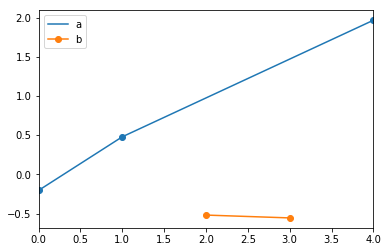

In [45]:
#grouped["data1"].plot(legend=True)
grouped["data1"].plot(kind="line",marker="o", legend=True)

In [46]:
"""カスタム集合関数"""
def peak_to_peak(arr):
    return arr.max() - arr.min()
grouped.agg(peak_to_peak)

,data1,data2
key1,,
a,2.170488,1.300498
b,0.036292,0.487276


In [47]:
grouped.describe()

data1                                                              \
     count      mean       std       min       25%       50%       75%   
key1                                                                     
a      3.0  0.746672  1.109736 -0.204708  0.137118  0.478943  1.222362   
b      2.0 -0.537585  0.025662 -0.555730 -0.546657 -0.537585 -0.528512   

               data2                                                    \
           max count      mean       std       min       25%       50%   
key1                                                                     
a     1.965781   3.0  0.910916  0.712217  0.092908  0.669671  1.246435   
b    -0.519439   2.0  0.525384  0.344556  0.281746  0.403565  0.525384   

                          
           75%       max  
key1                      
a     1.319920  1.393406  
b     0.647203  0.769023

In [48]:
tips = pd.read_csv('ch08/tips.csv')
# Add tip percentage of total bill
tips['tip_pct'] = tips['tip'] / tips['total_bill']
tips[:6]

,total_bill,tip,sex,smoker,day,time,size,tip_pct
0,16.99,1.01,Female,No,Sun,Dinner,2,0.059447
1,10.34,1.66,Male,No,Sun,Dinner,3,0.160542
2,21.01,3.50,Male,No,Sun,Dinner,3,0.166587
3,23.68,3.31,Male,No,Sun,Dinner,2,0.139780
4,24.59,3.61,Female,No,Sun,Dinner,4,0.146808
5,25.29,4.71,Male,No,Sun,Dinner,4,0.186240


### 2.2.1 列に複数の関数を適用する

In [49]:
grouped = tips.groupby(['sex', 'smoker'])

In [50]:
grouped_pct = grouped['tip_pct']
grouped_pct.agg('mean')

sex     smoker
Female  No        0.156921
        Yes       0.182150
Male    No        0.160669
        Yes       0.152771
Name: tip_pct, dtype: float64

In [51]:
"""複数の集合関数を使う"""
grouped_pct.agg(['mean', 'std', peak_to_peak])

mean       std  peak_to_peak
sex    smoker                                  
Female No      0.156921  0.036421      0.195876
       Yes     0.182150  0.071595      0.360233
Male   No      0.160669  0.041849      0.220186
       Yes     0.152771  0.090588      0.674707

In [52]:
"""集合関数の項目エイリアス {'エイリアス': '集合演算'}"""
grouped_pct.agg([('foo', 'mean'), ('bar', np.std)])

foo       bar
sex    smoker                    
Female No      0.156921  0.036421
       Yes     0.182150  0.071595
Male   No      0.160669  0.041849
       Yes     0.152771  0.090588

In [53]:
functions = ['count', 'mean', 'max']
result = grouped['tip_pct', 'total_bill'].agg(functions)
result

tip_pct                     total_bill                  
                count      mean       max      count       mean    max
sex    smoker                                                         
Female No          54  0.156921  0.252672         54  18.105185  35.83
       Yes         33  0.182150  0.416667         33  17.977879  44.30
Male   No          97  0.160669  0.291990         97  19.791237  48.33
       Yes         60  0.152771  0.710345         60  22.284500  50.81

In [54]:
result['tip_pct']

count      mean       max
sex    smoker                           
Female No         54  0.156921  0.252672
       Yes        33  0.182150  0.416667
Male   No         97  0.160669  0.291990
       Yes        60  0.152771  0.710345

In [55]:
ftuples = [('Durchschnitt', 'mean'), ('Abweichung', np.var)]
grouped['tip_pct', 'total_bill'].agg(ftuples)

tip_pct              total_bill           
              Durchschnitt Abweichung Durchschnitt Abweichung
sex    smoker                                                
Female No         0.156921   0.001327    18.105185  53.092422
       Yes        0.182150   0.005126    17.977879  84.451517
Male   No         0.160669   0.001751    19.791237  76.152961
       Yes        0.152771   0.008206    22.284500  98.244673

In [56]:
grouped.agg({'tip' : np.max, 'size' : 'sum'})

tip  size
sex    smoker            
Female No       5.2   140
       Yes      6.5    74
Male   No       9.0   263
       Yes     10.0   150

In [57]:
grouped.agg({'tip_pct' : ['min', 'max', 'mean', 'std'],
             'size' : 'sum'})

tip_pct                               size
                    min       max      mean       std  sum
sex    smoker                                             
Female No      0.056797  0.252672  0.156921  0.036421  140
       Yes     0.056433  0.416667  0.182150  0.071595   74
Male   No      0.071804  0.291990  0.160669  0.041849  263
       Yes     0.035638  0.710345  0.152771  0.090588  150

### 9.2.2 集約されたデータを「インデックスされていない形式」で戻す

- インデックスの無効化 => ```as_index=False```

In [58]:
tips.groupby(['sex', 'smoker'], as_index=False).mean()

,sex,smoker,total_bill,tip,size,tip_pct
0,Female,No,18.105185,2.773519,2.592593,0.156921
1,Female,Yes,17.977879,2.931515,2.242424,0.182150
2,Male,No,19.791237,3.113402,2.711340,0.160669
3,Male,Yes,22.284500,3.051167,2.500000,0.152771


## 9.3 グループ指向の演算と変形
- transform
- apply

In [59]:
df

,data1,data2,key1,key2
0,-0.204708,1.393406,a,one
1,0.478943,0.092908,a,two
2,-0.519439,0.281746,b,one
3,-0.555730,0.769023,b,two
4,1.965781,1.246435,a,one


In [60]:
"""集合演算の結果の接頭辞"""
k1_means = df.groupby('key1').mean().add_prefix('mean_')
k1_means

,mean_data1,mean_data2
key1,,
a,0.746672,0.910916
b,-0.537585,0.525384


In [61]:
pd.merge(df, k1_means, left_on='key1', right_index=True)

,data1,data2,key1,key2,mean_data1,mean_data2
0,-0.204708,1.393406,a,one,0.746672,0.910916
1,0.478943,0.092908,a,two,0.746672,0.910916
4,1.965781,1.246435,a,one,0.746672,0.910916
2,-0.519439,0.281746,b,one,-0.537585,0.525384
3,-0.555730,0.769023,b,two,-0.537585,0.525384


In [62]:
key = ['one', 'two', 'one', 'two', 'one']
people.groupby(key).mean()

,a,b,c,d,e
one,-0.082032,-1.063687,-1.047620,-0.884358,-0.028309
two,0.505275,-0.849512,0.075965,0.834983,0.452620


In [63]:
people.groupby(key).transform(np.mean)

,a,b,c,d,e
Joe,-0.082032,-1.063687,-1.047620,-0.884358,-0.028309
Steve,0.505275,-0.849512,0.075965,0.834983,0.452620
Wes,-0.082032,-1.063687,-1.047620,-0.884358,-0.028309
Jim,0.505275,-0.849512,0.075965,0.834983,0.452620
Travis,-0.082032,-1.063687,-1.047620,-0.884358,-0.028309


In [64]:
"""平均値を各値から引く"""
def demean(arr):
    return arr - arr.mean()
demeaned = people.groupby(key).transform(demean)
demeaned

,a,b,c,d,e
Joe,1.089221,-0.232534,1.322612,1.113271,1.381226
Steve,0.381154,-1.152125,-0.447807,0.834043,-0.891190
Wes,-0.457709,NaN,NaN,-0.136869,-0.548778
Jim,-0.381154,1.152125,0.447807,-0.834043,0.891190
Travis,-0.631512,0.232534,-1.322612,-0.976402,-0.832448


In [65]:
demeaned.groupby(key).mean()

,a,b,c,d,e
one,0.000000e+00,-1.110223e-16,0.0,7.401487e-17,0.0
two,-2.775558e-17,0.000000e+00,0.0,0.000000e+00,0.0


### 9.3.1 apply メソッド :  一般的な分離-適用-結合(split-apply-combine)の方法
- transform => np.meanのようにスカラー値か、変形後も同じサイズの配列を生成することが必要
- apply => 多分、行ごと、列ごとで演算を行える

In [66]:
tips.head(3)

,total_bill,tip,sex,smoker,day,time,size,tip_pct
0,16.99,1.01,Female,No,Sun,Dinner,2,0.059447
1,10.34,1.66,Male,No,Sun,Dinner,3,0.160542
2,21.01,3.50,Male,No,Sun,Dinner,3,0.166587


In [67]:
def top(df, n=5, column='tip_pct'):
#    return df.sort_index(by=column)[-n:] # deprecated
    return df.sort_values(by=column)[-n:]
top(tips, n=6)

,total_bill,tip,sex,smoker,day,time,size,tip_pct
109,14.31,4.00,Female,Yes,Sat,Dinner,2,0.279525
183,23.17,6.50,Male,Yes,Sun,Dinner,4,0.280535
232,11.61,3.39,Male,No,Sat,Dinner,2,0.291990
67,3.07,1.00,Female,Yes,Sat,Dinner,1,0.325733
178,9.60,4.00,Female,Yes,Sun,Dinner,2,0.416667
172,7.25,5.15,Male,Yes,Sun,Dinner,2,0.710345


In [68]:
tips.groupby('smoker').apply(top)

total_bill   tip     sex smoker   day    time  size   tip_pct
smoker                                                                   
No     88        24.71  5.85    Male     No  Thur   Lunch     2  0.236746
       185       20.69  5.00    Male     No   Sun  Dinner     5  0.241663
       51        10.29  2.60  Female     No   Sun  Dinner     2  0.252672
       149        7.51  2.00    Male     No  Thur   Lunch     2  0.266312
       232       11.61  3.39    Male     No   Sat  Dinner     2  0.291990
Yes    109       14.31  4.00  Female    Yes   Sat  Dinner     2  0.279525
       183       23.17  6.50    Male    Yes   Sun  Dinner     4  0.280535
       67         3.07  1.00  Female    Yes   Sat  Dinner     1  0.325733
       178        9.60  4.00  Female    Yes   Sun  Dinner     2  0.416667
       172        7.25  5.15    Male    Yes   Sun  Dinner     2  0.710345

In [69]:
tips.groupby(['smoker', 'day']).apply(top, n=1, column='total_bill')

total_bill    tip     sex smoker   day    time  size  \
smoker day                                                              
No     Fri  94        22.75   3.25  Female     No   Fri  Dinner     2   
       Sat  212       48.33   9.00    Male     No   Sat  Dinner     4   
       Sun  156       48.17   5.00    Male     No   Sun  Dinner     6   
       Thur 142       41.19   5.00    Male     No  Thur   Lunch     5   
Yes    Fri  95        40.17   4.73    Male    Yes   Fri  Dinner     4   
       Sat  170       50.81  10.00    Male    Yes   Sat  Dinner     3   
       Sun  182       45.35   3.50    Male    Yes   Sun  Dinner     3   
       Thur 197       43.11   5.00  Female    Yes  Thur   Lunch     4   

                  tip_pct  
smoker day                 
No     Fri  94   0.142857  
       Sat  212  0.186220  
       Sun  156  0.103799  
       Thur 142  0.121389  
Yes    Fri  95   0.117750  
       Sat  170  0.196812  
       Sun  182  0.077178  
       Thur 197  0.115982

In [70]:
result = tips.groupby('smoker')['tip_pct'].describe()
result

,count,mean,std,min,25%,50%,75%,max
smoker,,,,,,,,
No,151.0,0.159328,0.039910,0.056797,0.136906,0.155625,0.185014,0.291990
Yes,93.0,0.163196,0.085119,0.035638,0.106771,0.153846,0.195059,0.710345


In [71]:
result.unstack('smoker')

       smoker
count  No        151.000000
       Yes        93.000000
mean   No          0.159328
       Yes         0.163196
std    No          0.039910
       Yes         0.085119
min    No          0.056797
       Yes         0.035638
25%    No          0.136906
       Yes         0.106771
50%    No          0.155625
       Yes         0.153846
75%    No          0.185014
       Yes         0.195059
max    No          0.291990
       Yes         0.710345
dtype: float64

#### 9.3.1.1 グループキーの抑制
- グループキーを無効にして、階層性を無くしている
- 右側に階層インデックスが表示されていないだけ

In [72]:
tips.groupby('smoker', group_keys=False).apply(top)

,total_bill,tip,sex,smoker,day,time,size,tip_pct
88,24.71,5.85,Male,No,Thur,Lunch,2,0.236746
185,20.69,5.00,Male,No,Sun,Dinner,5,0.241663
51,10.29,2.60,Female,No,Sun,Dinner,2,0.252672
149,7.51,2.00,Male,No,Thur,Lunch,2,0.266312
232,11.61,3.39,Male,No,Sat,Dinner,2,0.291990
109,14.31,4.00,Female,Yes,Sat,Dinner,2,0.279525
183,23.17,6.50,Male,Yes,Sun,Dinner,4,0.280535
67,3.07,1.00,Female,Yes,Sat,Dinner,1,0.325733
178,9.60,4.00,Female,Yes,Sun,Dinner,2,0.416667
172,7.25,5.15,Male,Yes,Sun,Dinner,2,0.710345


### 9.3.2 分位点とビン分析
- cut => データの数量で分割
- qcut => データの分位点で分割

In [73]:
"""cut"""
data = pd.cut(range(30), bins=3, labels=["S","M","L"])
data

[S, S, S, S, S, ..., L, L, L, L, L]
Length: 30
Categories (3, object): [L < M < S]

In [74]:
data.value_counts()

L    10
M    10
S    10
dtype: int64

In [75]:
"""qcut"""
data = pd.qcut(range(30), q=[0.0, 0.25, 0.75, 1.0], labels=["S","M","L"])
data.value_counts()

L     8
M    14
S     8
dtype: int64

In [76]:
frame = DataFrame({'data1': np.random.randn(100),
                   'data2': np.random.randn(100)})
factor = pd.cut(frame.data1, 4) # 4分割(数量ベース)
factor[:10]

0    (-1.186, -0.0674]
1     (-2.309, -1.186]
2     (-0.0674, 1.051]
3     (-0.0674, 1.051]
4    (-1.186, -0.0674]
5     (-0.0674, 1.051]
6     (-0.0674, 1.051]
7     (-0.0674, 1.051]
8     (-0.0674, 1.051]
9     (-0.0674, 1.051]
Name: data1, dtype: category
Categories (4, interval[float64]): [(-2.309, -1.186] < (-1.186, -0.0674] < (-0.0674, 1.051] < (1.051, 2.169]]

In [77]:
#pd.cut?

In [78]:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}

grouped = frame.data2.groupby(factor)
grouped.apply(get_stats).unstack()

#ADAPT the output is not sorted in the book while this is the case now (swap first two lines)

,count,max,mean,min
data1,,,,
"(-2.309, -1.186]",11.0,2.224660,0.180889,-1.741494
"(-1.186, -0.0674]",34.0,1.920784,-0.048207,-1.563740
"(-0.0674, 1.051]",46.0,2.068708,-0.012260,-2.420294
"(1.051, 2.169]",9.0,1.270025,-0.532541,-2.644409


In [79]:
for f in factor.value_counts().keys():
    print("{0:<20}, {1:<10}, {2:<10} , {3:<10}".format(str(f), f.left, f.right, f.right-f.left))

(-0.0674, 1.051]    , -0.0674   , 1.051      , 1.1183999999999998
(-1.186, -0.0674]   , -1.186    , -0.0674    , 1.1186    
(-2.309, -1.186]    , -2.309    , -1.186     , 1.1230000000000002
(1.051, 2.169]      , 1.051     , 2.169      , 1.118     


In [80]:
# Return quantile numbers
grouping = pd.qcut(frame.data1, 10, labels=False)

grouped = frame.data2.groupby(grouping)
grouped.apply(get_stats).unstack()

,count,max,mean,min
data1,,,,
0,10.0,2.224660,0.124335,-1.741494
1,10.0,1.440167,-0.317525,-1.563740
2,10.0,1.920784,-0.070213,-1.413416
3,10.0,1.457300,0.048634,-1.168634
4,10.0,1.022872,0.185396,-0.825020
5,10.0,1.107425,-0.011720,-1.844788
6,10.0,1.755108,-0.157155,-2.420294
7,10.0,2.068708,0.311639,-1.824505
8,10.0,1.436603,-0.255693,-1.213851


### 9.3.3 グループごとに指定する値でܽ欠損値を埋める

In [81]:
s = Series(np.random.randn(6))
s[::2] = np.nan
s

0         NaN
1   -0.258867
2         NaN
3   -1.260421
4         NaN
5   -1.070241
dtype: float64

In [82]:
"""平均値で埋める"""
s.fillna(s.mean())

0   -0.863176
1   -0.258867
2   -0.863176
3   -1.260421
4   -0.863176
5   -1.070241
dtype: float64

In [83]:
states = ['Ohio', 'New York', 'Vermont', 'Florida',
          'Oregon', 'Nevada', 'California', 'Idaho']
group_key = ['East'] * 4 + ['West'] * 4 # R c( rep("East",4), rep("West,4))
data = Series(np.random.randn(8), index=states)
data[['Vermont', 'Nevada', 'Idaho']] = np.nan
data

Ohio          0.804223
New York     -0.156736
Vermont            NaN
Florida      -0.887104
Oregon       -0.977936
Nevada             NaN
California    0.483338
Idaho              NaN
dtype: float64

In [84]:
data.groupby(group_key).mean()

East   -0.079872
West   -0.247299
dtype: float64

In [85]:
"""欠損値をグループの平均で埋める"""
fill_mean = lambda g: g.fillna(g.mean())
data.groupby(group_key).apply(fill_mean)

Ohio          0.804223
New York     -0.156736
Vermont      -0.079872
Florida      -0.887104
Oregon       -0.977936
Nevada       -0.247299
California    0.483338
Idaho        -0.247299
dtype: float64

In [86]:
"""予め用意した値で埋める"""
fill_values = {'East': 0.5, 'West': -1}
fill_func = lambda g: g.fillna(fill_values[g.name])

data.groupby(group_key).apply(fill_func)

Ohio          0.804223
New York     -0.156736
Vermont       0.500000
Florida      -0.887104
Oregon       -0.977936
Nevada       -1.000000
California    0.483338
Idaho        -1.000000
dtype: float64

### 9.3.4 ランダムサンプリングと順列

- モンテカルロ法とかランダムサンプリングに使える

In [87]:
# Hearts, Spades, Clubs, Diamonds
suits = ['H', 'S', 'C', 'D']
###card_val = (range(1, 11) + [10] * 3) * 4
card_val = (list( range(1, 11) )  + [10] * 3) * 4
###base_names = ['A'] + range(2, 11) + ['J', 'K', 'Q']
base_names = ['A'] + list( range(2, 11) ) + ['J', 'K', 'Q']
cards = []
for suit in ['H', 'S', 'C', 'D']:
    cards.extend(str(num) + suit for num in base_names)

deck = Series(card_val, index=cards)

In [88]:
"""カードの組"""
deck[:13]

AH      1
2H      2
3H      3
4H      4
5H      5
6H      6
7H      7
8H      8
9H      9
10H    10
JH     10
KH     10
QH     10
dtype: int64

In [89]:
#np.take?  # fancy index と同じ動作

In [90]:
"""順列の一組"""
np.random.permutation(10)

array([6, 9, 8, 1, 2, 5, 4, 7, 0, 3])

In [91]:
"""一組のカードからn枚引く"""
def draw(deck, n=5):
    return deck.take(np.random.permutation(len(deck))[:n]) # 先頭n枚を返す
draw(deck)

9C     9
7D     7
8C     8
KD    10
QD    10
dtype: int64

In [92]:
"""n枚のカードそれぞれの絵柄に対して、2枚引く?"""
get_suit = lambda card: card[-1] # last letter is suit 最後の文字がは絵柄
#deck.groupby(get_suit).apply(draw, n=2)
deck.groupby(get_suit).apply(draw, n=2)

C  QC     10
   6C      6
D  10D    10
   QD     10
H  AH      1
   7H      7
S  QS     10
   9S      9
dtype: int64

In [93]:
# alternatively
deck.groupby(get_suit, group_keys=False).apply(draw, n=2)

3C      3
JC     10
KD     10
AD      1
QH     10
10H    10
KS     10
5S      5
dtype: int64

### 9.3.5 グループの加重平均と相関

In [94]:
df = DataFrame({'category': ['a', 'a', 'a', 'a', 'b', 'b', 'b', 'b'],
                'data': np.random.randn(8),
                'weights': np.random.rand(8)})
df

,category,data,weights
0,a,0.449880,0.958500
1,a,0.617487,0.291053
2,a,0.336680,0.686678
3,a,-0.062649,0.042228
4,b,-0.023295,0.062504
5,b,1.072407,0.814399
6,b,0.760617,0.436618
7,b,1.204850,0.392068


In [95]:
grouped = df.groupby('category')
get_wavg = lambda g: np.average(g['data'], weights=g['weights'])
grouped.apply(get_wavg)

category
a    0.424309
b    0.982882
dtype: float64

In [96]:
"""Yahoo Finance S&Pインデックス といくつかの株式"""
close_px = pd.read_csv('ch09/stock_px.csv', parse_dates=True, index_col=0)
close_px.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2214 entries, 2003-01-02 to 2011-10-14
Data columns (total 4 columns):
AAPL    2214 non-null float64
MSFT    2214 non-null float64
XOM     2214 non-null float64
SPX     2214 non-null float64
dtypes: float64(4)
memory usage: 86.5 KB


In [97]:
close_px[-4:]

,AAPL,MSFT,XOM,SPX
2011-10-11,400.29,27.00,76.27,1195.54
2011-10-12,402.19,26.96,77.16,1207.25
2011-10-13,408.43,27.18,76.37,1203.66
2011-10-14,422.00,27.27,78.11,1224.58


In [98]:
"""年次の相関 (vs SPX)"""
rets = close_px.pct_change().dropna()
spx_corr = lambda x: x.corrwith(x['SPX'])
by_year = rets.groupby(lambda x: x.year)
by_year.apply(spx_corr)

,AAPL,MSFT,XOM,SPX
2003,0.541124,0.745174,0.661265,1.0
2004,0.374283,0.588531,0.557742,1.0
2005,0.467540,0.562374,0.631010,1.0
2006,0.428267,0.406126,0.518514,1.0
2007,0.508118,0.658770,0.786264,1.0
2008,0.681434,0.804626,0.828303,1.0
2009,0.707103,0.654902,0.797921,1.0
2010,0.710105,0.730118,0.839057,1.0
2011,0.691931,0.800996,0.859975,1.0


In [99]:
# Annual correlation of Apple with Microsoft
by_year.apply(lambda g: g['AAPL'].corr(g['MSFT']))

2003    0.480868
2004    0.259024
2005    0.300093
2006    0.161735
2007    0.417738
2008    0.611901
2009    0.432738
2010    0.571946
2011    0.581987
dtype: float64

### 9.3.6 グループ~~指向~~ごとの線形回帰
<p>Example: Group-wise linear regression</p>

In [100]:
import statsmodels.api as sm
def regress(data, yvar, xvars):
    Y = data[yvar]
    X = data[xvars]
    X['intercept'] = 1.
    result = sm.OLS(Y, X).fit() # 最小二乗法による線形回帰
    return result.params

C:\Users\osawa\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [101]:
by_year

In [102]:
list(by_year)[0][1][:3] # 最初の年の、中身の2番目(DataFrame)、上から3行

,AAPL,MSFT,XOM,SPX
2003-01-03,0.006757,0.001421,0.000684,-0.000484
2003-01-06,0.000000,0.017975,0.024624,0.022474
2003-01-07,-0.002685,0.019052,-0.033712,-0.006545


In [103]:
"""AppleとSPXの年ごとの線形回帰"""
by_year.apply(regress, 'AAPL', ['SPX'])

,SPX,intercept
2003,1.195406,0.000710
2004,1.363463,0.004201
2005,1.766415,0.003246
2006,1.645496,0.000080
2007,1.198761,0.003438
2008,0.968016,-0.001110
2009,0.879103,0.002954
2010,1.052608,0.001261
2011,0.806605,0.001514


- 試してみた

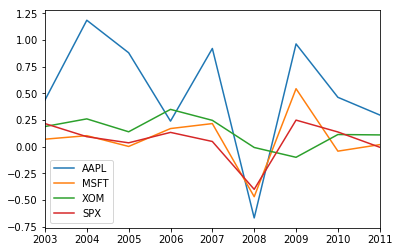

In [104]:
data = rets.groupby(pd.TimeGrouper(freq="A")).aggregate(np.sum)
data.plot()

## 9.4 ピボットテーブルとクロス集計

In [105]:
tips.pivot_table(index=['sex', 'smoker'])

size       tip   tip_pct  total_bill
sex    smoker                                          
Female No      2.592593  2.773519  0.156921   18.105185
       Yes     2.242424  2.931515  0.182150   17.977879
Male   No      2.711340  3.113402  0.160669   19.791237
       Yes     2.500000  3.051167  0.152771   22.284500

In [106]:
tips.pivot_table(['tip_pct', 'size'], index=['sex', 'day'],
                 columns='smoker')

size             tip_pct          
smoker             No       Yes        No       Yes
sex    day                                         
Female Fri   2.500000  2.000000  0.165296  0.209129
       Sat   2.307692  2.200000  0.147993  0.163817
       Sun   3.071429  2.500000  0.165710  0.237075
       Thur  2.480000  2.428571  0.155971  0.163073
Male   Fri   2.000000  2.125000  0.138005  0.144730
       Sat   2.656250  2.629630  0.162132  0.139067
       Sun   2.883721  2.600000  0.158291  0.173964
       Thur  2.500000  2.300000  0.165706  0.164417

In [107]:
tips.pivot_table(['tip_pct', 'size'], index=['sex', 'day'],
                 columns='smoker', margins=True)

size                       tip_pct                    
smoker             No       Yes       All        No       Yes       All
sex    day                                                             
Female Fri   2.500000  2.000000  2.111111  0.165296  0.209129  0.199388
       Sat   2.307692  2.200000  2.250000  0.147993  0.163817  0.156470
       Sun   3.071429  2.500000  2.944444  0.165710  0.237075  0.181569
       Thur  2.480000  2.428571  2.468750  0.155971  0.163073  0.157525
Male   Fri   2.000000  2.125000  2.100000  0.138005  0.144730  0.143385
       Sat   2.656250  2.629630  2.644068  0.162132  0.139067  0.151577
       Sun   2.883721  2.600000  2.810345  0.158291  0.173964  0.162344
       Thur  2.500000  2.300000  2.433333  0.165706  0.164417  0.165276
All          2.668874  2.408602  2.569672  0.159328  0.163196  0.160803

In [108]:
tips.pivot_table('tip_pct', index=['sex', 'smoker'], columns='day',
                 aggfunc=len, margins=True)

day             Fri   Sat   Sun  Thur    All
sex    smoker                               
Female No       2.0  13.0  14.0  25.0   54.0
       Yes      7.0  15.0   4.0   7.0   33.0
Male   No       2.0  32.0  43.0  20.0   97.0
       Yes      8.0  27.0  15.0  10.0   60.0
All            19.0  87.0  76.0  62.0  244.0

In [109]:
tips.pivot_table('size', index=['time', 'sex', 'smoker'],
                 columns='day', aggfunc='sum', fill_value=0)

day                   Fri  Sat  Sun  Thur
time   sex    smoker                     
Dinner Female No        2   30   43     2
              Yes       8   33   10     0
       Male   No        4   85  124     0
              Yes      12   71   39     0
Lunch  Female No        3    0    0    60
              Yes       6    0    0    17
       Male   No        0    0    0    50
              Yes       5    0    0    23

### 9.4.1 crosstabメソッド：クロス集計

In [110]:
#from StringIO import StringIO
from io import StringIO
data = """\
Sample    Gender    Handedness
1    Female    Right-handed
2    Male    Left-handed
3    Female    Right-handed
4    Male    Right-handed
5    Male    Left-handed
6    Male    Right-handed
7    Female    Right-handed
8    Female    Left-handed
9    Male    Right-handed
10    Female    Right-handed"""
data = pd.read_table(StringIO(data), sep='\s+')

In [111]:
data

,Sample,Gender,Handedness
0,1,Female,Right-handed
1,2,Male,Left-handed
2,3,Female,Right-handed
3,4,Male,Right-handed
4,5,Male,Left-handed
5,6,Male,Right-handed
6,7,Female,Right-handed
7,8,Female,Left-handed
8,9,Male,Right-handed
9,10,Female,Right-handed


In [112]:
pd.crosstab(data.Gender, data.Handedness, margins=True)

Handedness,Left-handed,Right-handed,All
Gender,,,
Female,1,4,5
Male,2,3,5
All,3,7,10


In [113]:
pd.crosstab([tips.time, tips.day], tips.smoker, margins=True)

smoker        No  Yes  All
time   day                
Dinner Fri     3    9   12
       Sat    45   42   87
       Sun    57   19   76
       Thur    1    0    1
Lunch  Fri     1    6    7
       Thur   44   17   61
All          151   93  244

## 9.5 例： 2012年の連邦選挙委員会のデータベース

- 政治的なキャンペーンへの寄付に関するデータ

In [114]:
fec = pd.read_csv('ch09/P00000001-ALL.csv')

C:\Users\osawa\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [115]:
fec.shape

(1001731, 16)

In [116]:
fec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001731 entries, 0 to 1001730
Data columns (total 16 columns):
cmte_id              1001731 non-null object
cand_id              1001731 non-null object
cand_nm              1001731 non-null object
contbr_nm            1001731 non-null object
contbr_city          1001712 non-null object
contbr_st            1001727 non-null object
contbr_zip           1001620 non-null object
contbr_employer      988002 non-null object
contbr_occupation    993301 non-null object
contb_receipt_amt    1001731 non-null float64
contb_receipt_dt     1001731 non-null object
receipt_desc         14166 non-null object
memo_cd              92482 non-null object
memo_text            97770 non-null object
form_tp              1001731 non-null object
file_num             1001731 non-null int64
dtypes: float64(1), int64(1), object(14)
memory usage: 122.3+ MB


In [117]:
#fec.ix[123456]
fec.iloc[123456]

cmte_id                             C00431445
cand_id                             P80003338
cand_nm                         Obama, Barack
contbr_nm                         ELLMAN, IRA
contbr_city                             TEMPE
contbr_st                                  AZ
contbr_zip                          852816719
contbr_employer      ARIZONA STATE UNIVERSITY
contbr_occupation                   PROFESSOR
contb_receipt_amt                          50
contb_receipt_dt                    01-DEC-11
receipt_desc                              NaN
memo_cd                                   NaN
memo_text                                 NaN
form_tp                                 SA17A
file_num                               772372
Name: 123456, dtype: object

In [118]:
unique_cands = fec.cand_nm.unique()
unique_cands

array(['Bachmann, Michelle', 'Romney, Mitt', 'Obama, Barack',
       "Roemer, Charles E. 'Buddy' III", 'Pawlenty, Timothy',
       'Johnson, Gary Earl', 'Paul, Ron', 'Santorum, Rick', 'Cain, Herman',
       'Gingrich, Newt', 'McCotter, Thaddeus G', 'Huntsman, Jon',
       'Perry, Rick'], dtype=object)

In [119]:
unique_cands[2]

'Obama, Barack'

In [120]:
parties = {'Bachmann, Michelle': 'Republican',
           'Cain, Herman': 'Republican',
           'Gingrich, Newt': 'Republican',
           'Huntsman, Jon': 'Republican',
           'Johnson, Gary Earl': 'Republican',
           'McCotter, Thaddeus G': 'Republican',
           'Obama, Barack': 'Democrat',
           'Paul, Ron': 'Republican',
           'Pawlenty, Timothy': 'Republican',
           'Perry, Rick': 'Republican',
           "Roemer, Charles E. 'Buddy' III": 'Republican',
           'Romney, Mitt': 'Republican',
           'Santorum, Rick': 'Republican'}

In [121]:
fec.cand_nm[123456:123461]

123456    Obama, Barack
123457    Obama, Barack
123458    Obama, Barack
123459    Obama, Barack
123460    Obama, Barack
Name: cand_nm, dtype: object

In [122]:
"""候補者から政党を結びつける"""
fec.cand_nm[123456:123461].map(parties)

123456    Democrat
123457    Democrat
123458    Democrat
123459    Democrat
123460    Democrat
Name: cand_nm, dtype: object

In [123]:
# Add it as a column
fec['party'] = fec.cand_nm.map(parties)

In [124]:
fec['party'].value_counts()

Democrat      593746
Republican    407985
Name: party, dtype: int64

- 寄付には払い戻しも含まれているので、取り除く

In [125]:
(fec.contb_receipt_amt > 0).value_counts()

True     991475
False     10256
Name: contb_receipt_amt, dtype: int64

In [126]:
fec = fec[fec.contb_receipt_amt > 0]

- オバマとロムニーだけを含むサブセットも用意する

In [127]:
fec_mrbo = fec[fec.cand_nm.isin(['Obama, Barack', 'Romney, Mitt'])]

### 9.5.1 職務と勤務先による寄付金の統計

In [128]:
fec.contbr_occupation.value_counts()[:10]

RETIRED                                   233990
INFORMATION REQUESTED                      35107
ATTORNEY                                   34286
HOMEMAKER                                  29931
PHYSICIAN                                  23432
INFORMATION REQUESTED PER BEST EFFORTS     21138
ENGINEER                                   14334
TEACHER                                    13990
CONSULTANT                                 13273
PROFESSOR                                  12555
Name: contbr_occupation, dtype: int64

In [129]:
"""職業タイプのリマップ"""
occ_mapping = {
   'INFORMATION REQUESTED PER BEST EFFORTS' : 'NOT PROVIDED',
   'INFORMATION REQUESTED' : 'NOT PROVIDED',
   'INFORMATION REQUESTED (BEST EFFORTS)' : 'NOT PROVIDED',
   'C.E.O.': 'CEO'
}

# If no mapping provided, return x
f = lambda x: occ_mapping.get(x, x)
fec.contbr_occupation = fec.contbr_occupation.map(f)

In [130]:
"""勤務先のリマップ"""
emp_mapping = {
   'INFORMATION REQUESTED PER BEST EFFORTS' : 'NOT PROVIDED',
   'INFORMATION REQUESTED' : 'NOT PROVIDED',
   'SELF' : 'SELF-EMPLOYED',
   'SELF EMPLOYED' : 'SELF-EMPLOYED',
}

# If no mapping provided, return x
f = lambda x: emp_mapping.get(x, x)
fec.contbr_employer = fec.contbr_employer.map(f)

In [131]:
by_occupation = fec.pivot_table('contb_receipt_amt',
                                index='contbr_occupation',
                                columns='party', aggfunc='sum')

In [132]:
over_2mm = by_occupation[by_occupation.sum(1) > 2000000]
over_2mm

party,Democrat,Republican
contbr_occupation,,
ATTORNEY,11141982.97,7.477194e+06
CEO,2074974.79,4.211041e+06
CONSULTANT,2459912.71,2.544725e+06
ENGINEER,951525.55,1.818374e+06
EXECUTIVE,1355161.05,4.138850e+06
HOMEMAKER,4248875.80,1.363428e+07
INVESTOR,884133.00,2.431769e+06
LAWYER,3160478.87,3.912243e+05
MANAGER,762883.22,1.444532e+06


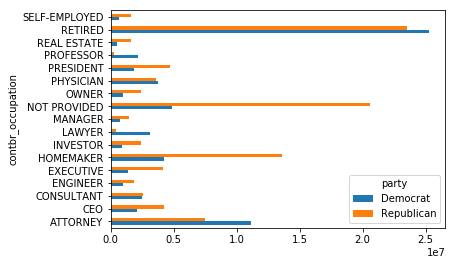

In [133]:
over_2mm.plot(kind='barh')

In [134]:
def get_top_amounts(group, key, n=5):
    totals = group.groupby(key)['contb_receipt_amt'].sum()

    # Order totals by key in descending order
    #return totals.order(ascending=False)[-n:]
    return totals.sort_values(ascending=False)[-n:]

In [135]:
grouped = fec_mrbo.groupby('cand_nm')
grouped.apply(get_top_amounts, 'contbr_occupation', n=7)

cand_nm        contbr_occupation                     
Obama, Barack  COMPUTER ASSISTANT                        3.0
               SPRINKLER FITTER FIRE PROTECTION SPECI    3.0
               ADMINISTRATION/INSTRUCTOR                 3.0
               LEAD UI/UX DEVELOPER                      3.0
               POLICY/ LAWYER                            3.0
               LAN/WAN ANALYST                           3.0
               SR MGR                                    3.0
Romney, Mitt   MD - UROLOGIST                            5.0
               DISTRICT REPRESENTATIVE                   5.0
               INDEPENDENT PROFESSIONAL                  3.0
               REMODELER & SEMI RETIRED                  3.0
               AFFORDABLE REAL ESTATE DEVELOPER          3.0
               IFC CONTRACTING SOLUTIONS                 3.0
               3RD GENERATION FAMILY BUSINESS OWNER      3.0
Name: contb_receipt_amt, dtype: float64

In [136]:
grouped.apply(get_top_amounts, 'contbr_employer', n=10)

cand_nm        contbr_employer                   
Obama, Barack  SOLIYA                                3.0
               CARR ENTERPRISES                      3.0
               PENN STATE DICKINSON SCHOOL OF LAW    3.0
               CADUCEUS OCCUPATIONAL MEDICINE        3.0
               N.A.                                  3.0
               REAL ENERGY CONSULTING SERVICES       3.0
               JPDSYSTEMS, LLC                       3.0
               CASS REGIONAL MED. CENTER             2.5
               ARCON CORP                            2.0
               THE VICTORIA GROUP, INC.              2.0
Romney, Mitt   EASTHAM CAPITAL                       5.0
               GREGORY GALLIVAN                      5.0
               DIRECT LENDERS LLC                    5.0
               LOUGH INVESTMENT ADVISORY LLC         4.0
               WATERWORKS INDUSRTIES                 3.0
               WILL MERRIFIELD                       3.0
               HONOLD COMMUNICTAIONS  

### 9.5.2 寄付金のビン分割

In [137]:
bins = np.array([0, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000])
labels = pd.cut(fec_mrbo.contb_receipt_amt, bins)
labels

411           (10, 100]
412         (100, 1000]
413         (100, 1000]
414           (10, 100]
415           (10, 100]
416           (10, 100]
417         (100, 1000]
418           (10, 100]
419         (100, 1000]
420           (10, 100]
421           (10, 100]
422         (100, 1000]
423         (100, 1000]
424         (100, 1000]
425         (100, 1000]
426         (100, 1000]
427       (1000, 10000]
428         (100, 1000]
429         (100, 1000]
430           (10, 100]
431       (1000, 10000]
432         (100, 1000]
433         (100, 1000]
434         (100, 1000]
435         (100, 1000]
436         (100, 1000]
437           (10, 100]
438         (100, 1000]
439         (100, 1000]
440           (10, 100]
              ...      
701356        (10, 100]
701357          (1, 10]
701358        (10, 100]
701359        (10, 100]
701360        (10, 100]
701361        (10, 100]
701362      (100, 1000]
701363        (10, 100]
701364        (10, 100]
701365        (10, 100]
701366        (1

In [138]:
grouped = fec_mrbo.groupby(['cand_nm', labels])
grouped.size().unstack(0)

cand_nm,"Obama, Barack","Romney, Mitt"
contb_receipt_amt,,
"(0, 1]",493.0,77.0
"(1, 10]",40070.0,3681.0
"(10, 100]",372280.0,31853.0
"(100, 1000]",153991.0,43357.0
"(1000, 10000]",22284.0,26186.0
"(10000, 100000]",2.0,1.0
"(100000, 1000000]",3.0,NaN
"(1000000, 10000000]",4.0,NaN


In [139]:
bucket_sums = grouped.contb_receipt_amt.sum().unstack(0)
bucket_sums

cand_nm,"Obama, Barack","Romney, Mitt"
contb_receipt_amt,,
"(0, 1]",318.24,77.00
"(1, 10]",337267.62,29819.66
"(10, 100]",20288981.41,1987783.76
"(100, 1000]",54798531.46,22363381.69
"(1000, 10000]",51753705.67,63942145.42
"(10000, 100000]",59100.00,12700.00
"(100000, 1000000]",1490683.08,NaN
"(1000000, 10000000]",7148839.76,NaN


In [140]:
normed_sums = bucket_sums.div(bucket_sums.sum(axis=1), axis=0)
normed_sums

cand_nm,"Obama, Barack","Romney, Mitt"
contb_receipt_amt,,
"(0, 1]",0.805182,0.194818
"(1, 10]",0.918767,0.081233
"(10, 100]",0.910769,0.089231
"(100, 1000]",0.710176,0.289824
"(1000, 10000]",0.447326,0.552674
"(10000, 100000]",0.823120,0.176880
"(100000, 1000000]",1.000000,NaN
"(1000000, 10000000]",1.000000,NaN


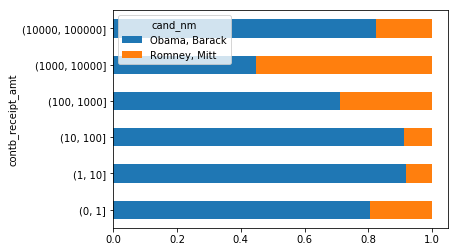

In [141]:
normed_sums[:-2].plot(kind='barh', stacked=True)

### 9.5.3 州別の寄付金の統計

In [142]:
grouped = fec_mrbo.groupby(['cand_nm', 'contbr_st'])
totals = grouped.contb_receipt_amt.sum().unstack(0).fillna(0)
totals = totals[totals.sum(1) > 100000]
totals[:10]

cand_nm,"Obama, Barack","Romney, Mitt"
contbr_st,,
AK,281840.15,86204.24
AL,543123.48,527303.51
AR,359247.28,105556.00
AZ,1506476.98,1888436.23
CA,23824984.24,11237636.60
CO,2132429.49,1506714.12
CT,2068291.26,3499475.45
DC,4373538.80,1025137.50
DE,336669.14,82712.00


In [143]:
percent = totals.div(totals.sum(1), axis=0)
percent[:10]

cand_nm,"Obama, Barack","Romney, Mitt"
contbr_st,,
AK,0.765778,0.234222
AL,0.507390,0.492610
AR,0.772902,0.227098
AZ,0.443745,0.556255
CA,0.679498,0.320502
CO,0.585970,0.414030
CT,0.371476,0.628524
DC,0.810113,0.189887
DE,0.802776,0.197224
